In [2]:
import numpy as np
import cv2
import matplotlib
import pickle
import h5py
import glob
import time
from random import shuffle
from collections import Counter
from sklearn.model_selection import train_test_split
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Dropout,Softmax
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,LeakyReLU,ReLU, AveragePooling2D
from keras.optimizers import SGD, Adam,RMSprop,Adagrad,Adadelta
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)


In [3]:
map_characters ={ 0:'R',1:'L',2:'F',3:'B'
                }
num_classes = len(map_characters)
pictures_per_class = 100 
test_size = 0.1
imgsPath = "Dataset/"
img_width = 32
img_height = 32

In [4]:
def load_pictures():
    pics = []
    labels = []
    
    for k, v in map_characters.items(): 
        pictures = [k for k in glob.glob(imgsPath + v +"/*.jpg")]        
        print(v + " : " + str(len(pictures))) 
        for i, pic in enumerate(pictures):
            tmp_img = cv2.imread(pic)
            tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB) ##
            tmp_img = cv2.resize(tmp_img, (img_height, img_width))          
            pics.append(tmp_img)
            labels.append(k)    
    return np.array(pics), np.array(labels)

In [5]:
def get_dataset(save=False, load=False):
    if load: 
        
        h5f = h5py.File('dataset.h5','r')
        X_train = h5f['X_train'][:]
        X_test = h5f['X_test'][:]
        h5f.close()
        
        
        h5f = h5py.File('labels.h5', 'r')
        y_train = h5f['y_train'][:]
        y_test = h5f['y_test'][:]
        h5f.close()
    else:
        
        X, y = load_pictures()
        y = keras.utils.to_categorical(y, num_classes) 
        
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
        if save: 
            h5f = h5py.File('dataset.h5', 'w')
            h5f.create_dataset('X_train', data=X_train)
            h5f.create_dataset('X_test', data=X_test)
            h5f.close()
            
            h5f = h5py.File('labels.h5', 'w')
            h5f.create_dataset('y_train', data=y_train)
            h5f.create_dataset('y_test', data=y_test)
            h5f.close()
    
    
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    print("Train", X_train.shape, y_train.shape)
    print("Test", X_test.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test   

In [96]:
X_train, X_test, y_train, y_test = get_dataset(save=False, load=False)

R : 100
L : 100
F : 100
B : 100
Train (360, 32, 32, 3) (360, 4)
Test (40, 32, 32, 3) (40, 4)


In [97]:
#PYNQ
def create_model_face(input_shape):
    model = Sequential([
    Conv2D(32, (5, 5), input_shape=input_shape, padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    ReLU(),

        
    Conv2D(32, (5, 5), activation='relu', padding='same'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
        
    Conv2D(64, (5, 5), activation='relu', padding='same'),
    AveragePooling2D(pool_size=(2, 2), strides=(2, 2)),
        
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')#有幾類?
    ])
    
    
    
    
    return model;

In [98]:
model = create_model_face((img_height, img_width, 3)) ### 初始化一個模型
model.summary() # 秀出模型架構

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        25632     
                                                                 
 average_pooling2d_2 (Averag  (None, 8, 8, 32)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)         

In [99]:
#original
sgd = SGD()
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy' ])

In [100]:
valation_size = 0.1
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=valation_size) 
print(X_train2.shape)
print(y_train2.shape)

(324, 32, 32, 3)
(324, 4)


In [101]:
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

In [102]:
batch_size = 128
epochs = 1000

history = model.fit(X_train2, y_train2,
         batch_size=batch_size,
         epochs=epochs,
         verbose=1,
         validation_data=(X_val, y_val),
         shuffle=True,   
         callbacks=[
             #LearningRateScheduler(lr_schedule),
             ModelCheckpoint('classifier_lab0811.h5', save_best_only=True)
         ]
                   )

Epoch 1/1000
3/3 [==============================] - 1s 179ms/step - loss: 1.3886 - accuracy: 0.2407 - val_loss: 1.3809 - val_accuracy: 0.3056
Epoch 2/1000
3/3 [==============================] - 0s 111ms/step - loss: 1.3879 - accuracy: 0.2407 - val_loss: 1.3822 - val_accuracy: 0.3056
Epoch 3/1000
3/3 [==============================] - 0s 113ms/step - loss: 1.3867 - accuracy: 0.2407 - val_loss: 1.3829 - val_accuracy: 0.3056
Epoch 4/1000
3/3 [==============================] - 0s 110ms/step - loss: 1.3860 - accuracy: 0.2407 - val_loss: 1.3837 - val_accuracy: 0.3056
Epoch 5/1000
3/3 [==============================] - 0s 106ms/step - loss: 1.3853 - accuracy: 0.2438 - val_loss: 1.3842 - val_accuracy: 0.3056
Epoch 6/1000
3/3 [==============================] - 0s 104ms/step - loss: 1.3846 - accuracy: 0.2562 - val_loss: 1.3849 - val_accuracy: 0.2778
Epoch 7/1000
3/3 [==============================] - 0s 108ms/step - loss: 1.3840 - accuracy: 0.2932 - val_loss: 1.3853 - val_accuracy: 0.2222
Epoch 

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])

In [117]:
max(history.history.get('val_accuracy'))

0.6666666865348816

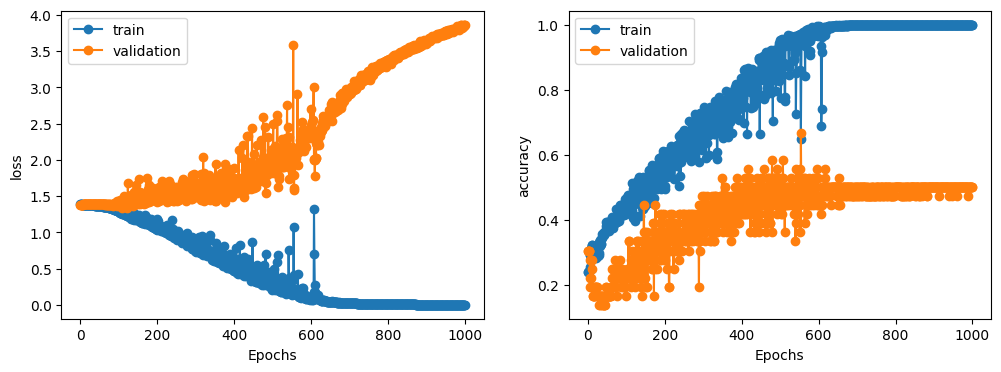

In [120]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'accuracy','val_accuracy')

plt.show()

In [121]:
#X_test = np.expand_dims(X_test, axis=-1)
loss,accuracy=model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 5ms/step - loss: 2.4418 - accuracy: 0.6500


In [122]:
accuracy

0.6499999761581421